In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd

import sklearn.pipeline
from sklearn.compose import ColumnTransformer
from transforms import FourierTransform, MeanTransform

In [4]:
from dataset import HARDatasetCrops

## Data

### Features

In [5]:
dataset = HARDatasetCrops('motionsense-dataset/train', 256, 50, 50, metadata_file='motionsense-dataset/data_subjects_info.csv')

Our dataset is composed of 5205 datapoints, each have shape `(256, 12)` because we have 12 signals of 256 samples each.

In [6]:
X_roll = np.array([sample[:,0] for sample, _, _ in dataset])
X_pitch = np.array([sample[:,1] for sample, _, _ in dataset])
X_yaw = np.array([sample[:,2] for sample, _, _ in dataset])
X_gx = np.array([sample[:,3] for sample, _, _ in dataset])
X_gy = np.array([sample[:,4] for sample, _, _ in dataset])
X_gz = np.array([sample[:,5] for sample, _, _ in dataset])
X_acc = np.array([np.linalg.norm(sample[:,6:9], axis=1) for sample, _, _ in dataset])
X_rot = np.array([np.linalg.norm(sample[:,9:12], axis=1) for sample, _, _ in dataset])

### Classes

In order to fit a `sklearn` model we should encode each class with a unique integer:

In [7]:
label_encoder = sklearn.preprocessing.LabelEncoder()
label_encoder.fit(list(dataset.CLASSES.keys()));

In [8]:
y = label_encoder.transform([cls for _, cls, _ in dataset])

#### Train-test splitting

We will first "stack" our features.

In [9]:
X = np.hstack([X_roll,
               X_pitch,
               X_yaw,
               X_gx,
               X_gy,
               X_gz,
               X_acc,
               X_rot])

X.shape

(4095, 2048)

#### PCA feature reduction

In [10]:
roll_transform = sklearn.pipeline.make_pipeline(
    MeanTransform()
)
pitch_transform = sklearn.pipeline.make_pipeline(
    MeanTransform()
)
yaw_transform = sklearn.pipeline.make_pipeline(
    MeanTransform()
)
gx_transform = sklearn.pipeline.make_pipeline(
    MeanTransform()
)
gy_transform = sklearn.pipeline.make_pipeline(
    MeanTransform()
)
gz_transform = sklearn.pipeline.make_pipeline(
    MeanTransform()
)
acc_transform = sklearn.pipeline.make_pipeline(
    FourierTransform(),
    PCA(n_components=32)
)
rot_transform = sklearn.pipeline.make_pipeline(
    FourierTransform(),
    PCA(n_components=32)
)

## Classification

In [11]:
metadata = np.array([metadata for _, _, metadata in dataset])

In [12]:
X = np.hstack([X, metadata])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

#### PCA feature reduction

In [14]:
features = ColumnTransformer([
    ("roll", roll_transform, slice(0, 256)),
    ("pitch", pitch_transform, slice(256, 512)),
    ("yaw", yaw_transform, slice(512, 768)),
    ("gravity-x", gx_transform, slice(768, 1024)),
    ("gravity-y", gy_transform, slice(1024, 1280)),
    ("gravity-z", gz_transform, slice(1280, 1536)),
    ("accelaration", acc_transform, slice(1536, 1792)),
    ("rotation", rot_transform, slice(1792, 2048)),
    ("metadata", "passthrough", slice(-4, X.shape[1]))
])

## Multilayer perceptron

In [15]:
import sklearn.neural_network

### Hyperparameter search

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV

In [17]:
cv = ShuffleSplit(n_splits=5, test_size=0.15, random_state=1)

In [70]:
clf = sklearn.pipeline.make_pipeline(
    features,
    sklearn.preprocessing.StandardScaler(),
    sklearn.neural_network.MLPClassifier()
)

In [71]:
param_grid =  {
    'mlpclassifier__hidden_layer_sizes': [2, 3, 4],
    'mlpclassifier__learning_rate_init': [0.001, 0.0005, 0.0001],
    'mlpclassifier__alpha': [0.01, 0.001, 0.0001],
    'mlpclassifier__early_stopping': [True],
    'mlpclassifier__max_iter': [300],
    'mlpclassifier__random_state': [1]
}

In [72]:
grid_search = GridSearchCV(clf, param_grid, cv=cv)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=1, test_size=0.15, train_size=None),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('roll',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('meantransform',
                                                                                          MeanTransform())],
                                                                      

In [73]:
grid_search.best_params_

{'mlpclassifier__alpha': 0.01,
 'mlpclassifier__early_stopping': True,
 'mlpclassifier__hidden_layer_sizes': 4,
 'mlpclassifier__learning_rate_init': 0.001,
 'mlpclassifier__max_iter': 300,
 'mlpclassifier__random_state': 1}

In [74]:
grid_search.best_score_

0.9553398058252427

In [75]:
import pandas as pd

In [76]:
cv_results = pd.DataFrame(grid_search.cv_results_)

In [77]:
cv_results.sort_values("rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mlpclassifier__alpha,param_mlpclassifier__early_stopping,param_mlpclassifier__hidden_layer_sizes,param_mlpclassifier__learning_rate_init,param_mlpclassifier__max_iter,param_mlpclassifier__random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,0.841672,0.171087,0.006134,0.000162,0.01,True,4,0.001,300,1,"{'mlpclassifier__alpha': 0.01, 'mlpclassifier_...",0.934466,0.956311,0.963592,0.953883,0.968447,0.955340,0.011650,1
24,0.868812,0.123359,0.006737,0.000703,0.0001,True,4,0.001,300,1,"{'mlpclassifier__alpha': 0.0001, 'mlpclassifie...",0.946602,0.956311,0.944175,0.949029,0.946602,0.948544,0.004176,2
15,0.869258,0.126058,0.006892,0.000525,0.001,True,4,0.001,300,1,"{'mlpclassifier__alpha': 0.001, 'mlpclassifier...",0.949029,0.961165,0.946602,0.944175,0.939320,0.948058,0.007298,3
7,1.148775,0.233223,0.006864,0.001073,0.01,True,4,0.0005,300,1,"{'mlpclassifier__alpha': 0.01, 'mlpclassifier_...",0.832524,0.941748,0.936893,0.817961,0.951456,0.896117,0.058240,4
16,1.118824,0.164130,0.006326,0.000198,0.001,True,4,0.0005,300,1,"{'mlpclassifier__alpha': 0.001, 'mlpclassifier...",0.936893,0.861650,0.847087,0.934466,0.851942,0.886408,0.040510,5
3,0.834264,0.216222,0.007405,0.000792,0.01,True,3,0.001,300,1,"{'mlpclassifier__alpha': 0.01, 'mlpclassifier_...",0.859223,0.890777,0.883495,0.898058,0.779126,0.862136,0.043511,6
25,1.111960,0.321720,0.006514,0.000454,0.0001,True,4,0.0005,300,1,"{'mlpclassifier__alpha': 0.0001, 'mlpclassifie...",0.936893,0.953883,0.509709,0.856796,0.941748,0.839806,0.168573,7
12,0.750092,0.326137,0.006584,0.000254,0.001,True,3,0.001,300,1,"{'mlpclassifier__alpha': 0.001, 'mlpclassifier...",0.766990,0.791262,0.766990,0.929612,0.927184,0.836408,0.075635,8
21,0.722252,0.246050,0.006411,0.000312,0.0001,True,3,0.001,300,1,"{'mlpclassifier__alpha': 0.0001, 'mlpclassifie...",0.766990,0.793689,0.893204,0.893204,0.798544,0.829126,0.053411,9
13,0.881261,0.190376,0.006790,0.000927,0.001,True,3,0.0005,300,1,"{'mlpclassifier__alpha': 0.001, 'mlpclassifier...",0.766990,0.864078,0.769417,0.771845,0.810680,0.796602,0.037363,10


In [78]:
print(classification_report(y_train, grid_search.predict(X_train), target_names=label_encoder.classes_))

              precision    recall  f1-score   support

         dws       0.87      0.78      0.82       236
         jog       0.97      0.91      0.94       265
         sit       0.99      1.00      0.99       663
         std       0.93      1.00      0.96       615
         ups       0.93      0.85      0.89       298
         wlk       0.95      0.98      0.97       666

    accuracy                           0.95      2743
   macro avg       0.94      0.92      0.93      2743
weighted avg       0.95      0.95      0.95      2743



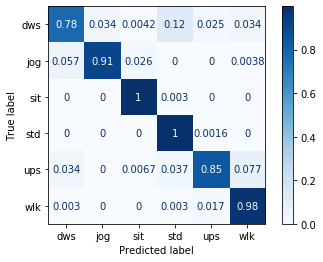

In [79]:
plot_confusion_matrix(grid_search, X_train, y_train,
                      display_labels=label_encoder.classes_,
                      cmap=plt.cm.Blues,
                      normalize="true")

In [80]:
print(classification_report(y_test, grid_search.predict(X_test), target_names=label_encoder.classes_))

              precision    recall  f1-score   support

         dws       0.88      0.64      0.74       123
         jog       0.96      0.92      0.94       119
         sit       0.99      0.99      0.99       341
         std       0.89      1.00      0.94       285
         ups       0.91      0.86      0.88       138
         wlk       0.94      0.98      0.96       346

    accuracy                           0.94      1352
   macro avg       0.93      0.90      0.91      1352
weighted avg       0.94      0.94      0.94      1352



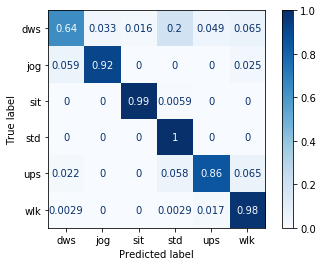

In [81]:
plot_confusion_matrix(grid_search, X_test, y_test,
                      display_labels=label_encoder.classes_,
                      cmap=plt.cm.Blues,
                      normalize="true")

### Class-balancing

In [50]:
import imblearn.pipeline
import imblearn.over_sampling

In [52]:
clf = imblearn.pipeline.Pipeline([
    ('features', features),
    ('balancing', imblearn.over_sampling.SMOTE(random_state=1)),
    ('normalize', sklearn.preprocessing.StandardScaler()),
    ('model', sklearn.neural_network.MLPClassifier(early_stopping=True, max_iter=300, random_state=1))
])

In [53]:
param_grid =  {
    'model__hidden_layer_sizes': [2, 3, 4],
    'model__learning_rate_init': [0.001, 0.0005, 0.0001],
    'model__alpha': [0.01, 0.001, 0.0001]
}

In [54]:
grid_search = GridSearchCV(clf, param_grid, cv=cv)

grid_search.fit(X_train, y_train)

/Users/sergio/PycharmProjects/MLEARN/venv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/sergio/PycharmProjects/MLEARN/venv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/sergio/PycharmProjects/MLEARN/venv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/sergio/PycharmProjects/MLEARN/venv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Op

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=1, test_size=0.15, train_size=None),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('features',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('roll',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('meantransform',
                                                                                          MeanTransform())],
                                                                               

In [55]:
grid_search.best_params_

{'model__alpha': 0.0001,
 'model__hidden_layer_sizes': 4,
 'model__learning_rate_init': 0.001}

In [56]:
grid_search.best_score_

0.9621359223300973

In [57]:
import pandas as pd

In [58]:
cv_results = pd.DataFrame(grid_search.cv_results_)

In [59]:
cv_results.sort_values("rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__alpha,param_model__hidden_layer_sizes,param_model__learning_rate_init,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
24,0.970589,0.158883,0.006192,0.000285,0.0001,4,0.001,"{'model__alpha': 0.0001, 'model__hidden_layer_...",0.953883,0.966019,0.951456,0.966019,0.973301,0.962136,0.008209,1
6,1.043675,0.139572,0.006736,0.000917,0.01,4,0.001,"{'model__alpha': 0.01, 'model__hidden_layer_si...",0.956311,0.966019,0.946602,0.961165,0.978155,0.961650,0.010457,2
15,0.918648,0.134335,0.006069,0.000223,0.001,4,0.001,"{'model__alpha': 0.001, 'model__hidden_layer_s...",0.941748,0.966019,0.946602,0.961165,0.978155,0.958738,0.013205,3
16,1.322700,0.160295,0.006105,0.000126,0.001,4,0.0005,"{'model__alpha': 0.001, 'model__hidden_layer_s...",0.949029,0.963592,0.941748,0.951456,0.956311,0.952427,0.007298,4
7,1.277122,0.127310,0.006284,0.000298,0.01,4,0.0005,"{'model__alpha': 0.01, 'model__hidden_layer_si...",0.949029,0.958738,0.932039,0.946602,0.970874,0.951456,0.012935,5
25,1.227781,0.227956,0.006047,0.000276,0.0001,4,0.0005,"{'model__alpha': 0.0001, 'model__hidden_layer_...",0.898058,0.958738,0.941748,0.958738,0.966019,0.944660,0.024628,6
12,1.112600,0.095687,0.006063,0.000236,0.001,3,0.001,"{'model__alpha': 0.001, 'model__hidden_layer_s...",0.919903,0.941748,0.944175,0.956311,0.961165,0.944660,0.014351,6
21,1.118584,0.034868,0.006000,0.000193,0.0001,3,0.001,"{'model__alpha': 0.0001, 'model__hidden_layer_...",0.922330,0.932039,0.936893,0.953883,0.953883,0.939806,0.012414,8
13,1.810017,0.288030,0.006075,0.000220,0.001,3,0.0005,"{'model__alpha': 0.001, 'model__hidden_layer_s...",0.922330,0.905340,0.946602,0.953883,0.939320,0.933495,0.017543,9
3,1.252790,0.393719,0.006880,0.000538,0.01,3,0.001,"{'model__alpha': 0.01, 'model__hidden_layer_si...",0.946602,0.915049,0.951456,0.885922,0.963592,0.932524,0.028281,10


In [60]:
print(classification_report(y_train, grid_search.predict(X_train), target_names=label_encoder.classes_))

              precision    recall  f1-score   support

         dws       0.88      0.94      0.91       236
         jog       0.98      0.94      0.96       265
         sit       0.99      1.00      0.99       663
         std       1.00      1.00      1.00       615
         ups       0.93      0.92      0.92       298
         wlk       0.98      0.97      0.98       666

    accuracy                           0.97      2743
   macro avg       0.96      0.96      0.96      2743
weighted avg       0.97      0.97      0.97      2743



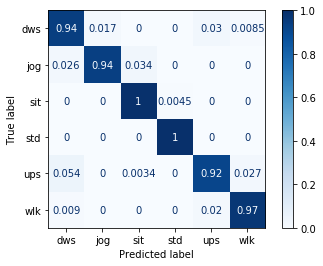

In [61]:
plot_confusion_matrix(grid_search, X_train, y_train,
                      display_labels=label_encoder.classes_,
                      cmap=plt.cm.Blues,
                      normalize="true")

In [62]:
print(classification_report(y_test, grid_search.predict(X_test), target_names=label_encoder.classes_))

              precision    recall  f1-score   support

         dws       0.85      0.93      0.89       123
         jog       0.98      0.92      0.95       119
         sit       0.99      0.99      0.99       341
         std       0.99      1.00      0.99       285
         ups       0.95      0.90      0.92       138
         wlk       0.97      0.97      0.97       346

    accuracy                           0.97      1352
   macro avg       0.96      0.95      0.95      1352
weighted avg       0.97      0.97      0.97      1352



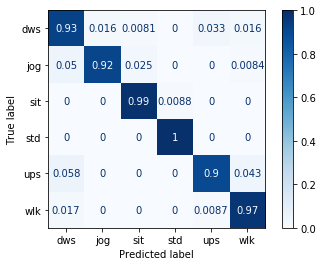

In [63]:
plot_confusion_matrix(grid_search, X_test, y_test,
                      display_labels=label_encoder.classes_,
                      cmap=plt.cm.Blues,
                      normalize="true")

## Convolutional Neural Network

In [87]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, SpatialDropout1D, Conv1D
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import to_categorical

In [ ]:
def create_model(optimizer="adam", dropout=0.1, nbr_features=2500, dense_nparams=256):
    model = Sequential()
    model.add(Dense(dense_nparams, activation='relu', input_shape=(nbr_features,))) 
    model.add(Dropout(dropout), )
    model.add(Dense(6, activation='sigmoid'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])
    return model